In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import datetime
import pathlib
import re
import pandas as pd
import lxml.etree as etree
import matplotlib.pyplot as plt

from sentence_transformers import SentenceTransformer
from nltk.corpus import stopwords
from sklearn.cluster import KMeans
from IPython.display import display, Markdown

sbert_model = SentenceTransformer('bert-base-nli-mean-tokens')
papers = pathlib.Path("../../papers_tei/")
papers_metadata = pd.read_csv("../data/spoc-paper-metadata.csv")
stop_words_list = stopwords.words('english')
TEI = {"tei": "http://www.tei-c.org/ns/1.0"}
special_char_re = re.compile(r'[^a-zA-Z]')

In [2]:
# Extracts text from Paper XML
xml_pathlist = [x for x in papers.glob('*.xml')]

In [3]:
def get_paper_text(paper_path):
    full_text = ''
    xml_doc = etree.XML(paper_path.read_bytes())
    for row in xml_doc.itertext():
        if "GROBID" in row:
            continue
        full_text += f"\n{row}"
    return full_text

def clean_text(paper_text):
    cleaned = []
    for char in paper_text.split():
        cleaned_char = special_char_re.sub(' ', char).lower()
        if cleaned_char in stop_words_list:
            continue
        cleaned.append(cleaned_char)
    return ' '.join(cleaned)

In [4]:
start = datetime.datetime.utcnow()
print(f"Started at {start}")
all_papers = []
for i,row in enumerate(xml_pathlist):
    raw_text = get_paper_text(row)
    record = [row.name, clean_text(raw_text)]
    all_papers.append(record)
    if not i%5 and i > 0:
        print(".", end="")
    if not i%100:
        print(f"{i}", end="")
end = datetime.datetime.utcnow()
print(f"\nFinished at {end}, total time {(end-start).seconds / 60.} minutes")

Started at 2021-04-28 22:08:01.962263
0....................100....................200....................300....................400....................500....................600....................700....................800....................900....................1000....................1100....................1200....................1300....................1400....................1500....................1600......
Finished at 2021-04-28 22:08:15.981932, total time 0.23333333333333334 minutes


In [5]:
all_df = pd.DataFrame(all_papers, columns=['XML file', 'Text'])

In [6]:
embed_start = datetime.datetime.utcnow()
print(f"Start Paper Embedding {embed_start}")
paper_embeddings = sbert_model.encode(all_df['Text'])
embed_end = datetime.datetime.utcnow()
print(f"Finished at {embed_end}, total time {(embed_end-embed_start).seconds / 60.}")

Start Paper Embedding 2021-04-28 22:08:23.209580
Finished at 2021-04-28 22:15:10.362337, total time 6.783333333333333


In [7]:
kmeans_start = datetime.datetime.utcnow()
print(f"Starting KMeans WCSS {kmeans_start}")
wcss = []
for i in range(1,50):
    kmeans = KMeans(n_clusters=i, init = 'k-means++', random_state=42)
    kmeans.fit(paper_embeddings)
    wcss.append(kmeans.inertia_)
    print(".", end="")
kmeans_end = datetime.datetime.utcnow()
print(f"\nFinished WCSS at {kmeans_end}, total time {(kmeans_end-kmeans_start).seconds / 60.}")

Starting KMeans WCSS 2021-04-28 22:15:10.415496
.................................................
Finished WCSS at 2021-04-28 22:16:32.115943, total time 1.35


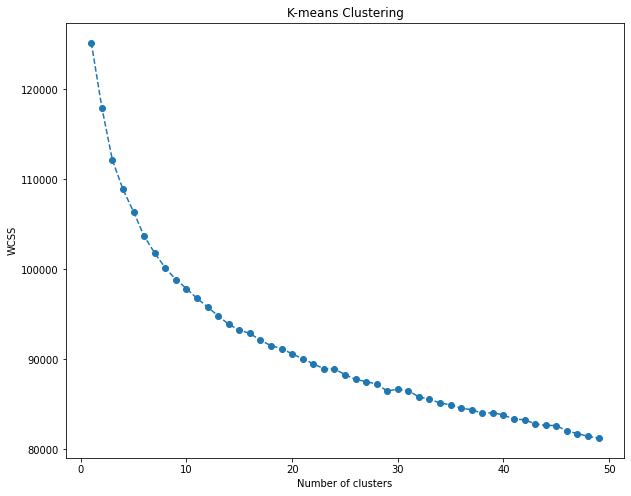

In [8]:
plt.figure(figsize=(10,8))
plt.plot(range(1,50), wcss, marker = 'o', linestyle='--')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.title('K-means Clustering')
plt.show()

## Investigation of Clusters 
Before we continue, we will create two functions `get_group` and `group_detail`. The `get_group` returns a list of papers clustered by group. The `group_detail` function displays details about a specific grouping in a cluster.

In [9]:
def get_groups(number: int) -> list:
    cluster_model = KMeans(n_clusters=number)
    predicted_cluster = cluster_model.fit_predict(paper_embeddings)
    clustered_papers = all_df.copy()
    clustered_papers['cluster'] = clustered_papers.index.map(lambda x: predicted_cluster[x])
    return [group for group in clustered_papers.groupby(by='cluster')]

def group_detail(groups: list, number: int):
    if number < 1 or number > len(groups):
        raise ValueError(f"Invalid number {number}, must be between 1 and {len(groups)}")
    group = groups[number-1]
    display(Markdown(f"# Details for Group Number {group[0]+1} of {len(groups)} clusters"))
    display(Markdown(f"## Number of papers: {len(group[1])}"))
    table = """<table>
        <tr><th>Number</th><th>File Name</th><th>Title</th><th>Year</th></tr>"""
    for i,row in enumerate(group[1].iterrows()):
        record = row[1]
        table += f"<tr><td>{i+1}</td><td>{record['XML file']}</td>"
        metadata = papers_metadata[papers_metadata["XML file"].isin([record['XML file']])]
        if len(metadata) > 0:
            table += f"<td>{metadata.iloc[0]['Title']}</td>"
            table += f"<td>{int(metadata.iloc[0]['Year'])}</td>"
        else:
            table += "<td>Unknown</td><td>Unknown</td>"
        table += "</tr>"
    tabel = "</table>"
    display(Markdown(table))
    

From the above graph, cluster 24 is where the graph is starting to flatten out so we will use 24 clusters and then investigate the specific groupings.

In [10]:
clusters24 = get_groups(24)

In [12]:
group_detail(clusters24, 10)

# Details for Group Number 10 of 24 clusters

## Number of papers: 58

<table>
        <tr><th>Number</th><th>File Name</th><th>Title</th><th>Year</th></tr><tr><td>1</td><td>hms_pv812ts3293.tei.xml</td><td>Battillaria attramentaria and its undescribed cercariae parasite: an inquiry into cercarial emergence</td><td>1980</td></tr><tr><td>2</td><td>ucla_1987_FischerRachel.tei.xml</td><td>Unknown</td><td>Unknown</td></tr><tr><td>3</td><td>hms_sp795pd7881.tei.xml</td><td>Tolerance of Tigriopus californicus (Baker, 1912) to slow increases in salinity produced by evaporation and hypersaline solutions</td><td>1996</td></tr><tr><td>4</td><td>hms_kd740kw1105.tei.xml</td><td>A study of the vesicomyid clams in the Monterey Bay Canyon: time lapse video analysis of adult reactions to varying sulfide levels, and examination of egg buoyancies and flotation rates</td><td>1993</td></tr><tr><td>5</td><td>hms_dz230sp9110.tei.xml</td><td>Population genetics of the red alga Mastocarpus papillatus on the California coast</td><td>1999</td></tr><tr><td>6</td><td>ucla_1978_SkollerDebbie_Sspinosus.tei.xml</td><td>Unknown</td><td>Unknown</td></tr><tr><td>7</td><td>hms_mj025vm9297.tei.xml</td><td>Activity patterns of the chiton Cyanoplax hartwegii (Mollusca: Polyplacophora)</td><td>1974</td></tr><tr><td>8</td><td>hms_jh784kt2099.tei.xml</td><td>Biochemical, population genetics, migration, and gene flow in a central California barnacle population</td><td>1990</td></tr><tr><td>9</td><td>hms_rr729zy4959.tei.xml</td><td>Nitric oxide promotes while cholinergic agonist and cyclic GMP inhibit neurite outgrowth of N1E-115 mouse neuroblastoma cells</td><td>1997</td></tr><tr><td>10</td><td>usc_1971_Coyer.tei.xml</td><td>Unknown</td><td>Unknown</td></tr><tr><td>11</td><td>fhl_2011_Katagi_26641.tei.xml</td><td>Molecular and Physical Relationships among Individuals in a Phoronis vancouverensis Clump</td><td>2011</td></tr><tr><td>12</td><td>hms_nf845vn5640.tei.xml</td><td>Chemoreception in Myxicola infundibulum</td><td>1976</td></tr><tr><td>13</td><td>hms_dj224jp8743.tei.xml</td><td>A behavioral light response in the chiton Stenoplax heathiana</td><td>1974</td></tr><tr><td>14</td><td>hms_dg065yp0282.tei.xml</td><td>Isolation of the small circular DNA from the brain of the Senorita, Oxyjulis californicus</td><td>1989</td></tr><tr><td>15</td><td>hms_sp871qz0159.tei.xml</td><td>Bisphenol A causes disruptions in the cell cycle of the zygotes and embryos of the purple sea urchin, Strongylocentrotus purpuratus</td><td>2004</td></tr><tr><td>16</td><td>hms_mc205gr4125.tei.xml</td><td>Calcium and magnesium flux via TRPM7</td><td>2005</td></tr><tr><td>17</td><td>hms_bt919wt2928.tei.xml</td><td>A comparative morphology of male reproductive structures in some California isopods</td><td>1973</td></tr><tr><td>18</td><td>hms_gz293yq4738.tei.xml</td><td>Certain aspects of the respiration rate of the cirratulid polychaete, Cirriformia spirabrancha (Moore, 1904)</td><td>1968</td></tr><tr><td>19</td><td>hms_kf764wh3371.tei.xml</td><td>Natural levels of DDE and the uptake of C14-DDT by different size classes of the mussel Mytilus californianus (Conrad, 1837)</td><td>1969</td></tr><tr><td>20</td><td>hms_wd131gs1203.tei.xml</td><td>An analysis of the endogenous rhythms in jumping activity in an intertidal collembolid population on the central California coast</td><td>1978</td></tr><tr><td>21</td><td>hms_cr507tx4660.tei.xml</td><td>Infestation of the sandy beach amphipod Orchestoidea corniculata by the mite Gammaridacarus brevisternalis (Laelaptidae)</td><td>1972</td></tr><tr><td>22</td><td>usc_1991_Sp_Western.tei.xml</td><td>Unknown</td><td>Unknown</td></tr><tr><td>23</td><td>hms_wk582vj1460.tei.xml</td><td>Hatching in Ascidia ceratodes and evidence for a hatching enzyme</td><td>1981</td></tr><tr><td>24</td><td>fhl_2014_Harrison_27260.tei.xml</td><td>The Affect of Ontogeny on Structure and Function of Preopercular Spines in Myoxocephalus polyacanthocephalus</td><td>2014</td></tr><tr><td>25</td><td>hms_zn059pq7833.tei.xml</td><td>Ceramide disrupts sperm motility and inhibits fertilization in the purple sea urchin, Strongylocentrotus purpuratus</td><td>1997</td></tr><tr><td>26</td><td>fhl_2012_Rincón_27074.tei.xml</td><td>High potential imaging technology for analysis of in situ patchiness</td><td>2012</td></tr><tr><td>27</td><td>usc_1992_Sp_Gala.tei.xml</td><td>Unknown</td><td>Unknown</td></tr><tr><td>28</td><td>hms_yr619fq5792.tei.xml</td><td>Effects of DDT on action potential discharge in the nerves of the sand crab, Emerita analoga (Simpson)</td><td>1971</td></tr><tr><td>29</td><td>hms_bc922nf3500.tei.xml</td><td>Observations on the sequence of events in the rejection reaction in Botryllus oozooids</td><td>1981</td></tr><tr><td>30</td><td>hms_kw682ny3339.tei.xml</td><td>Attrition on the Littorina planaxis population</td><td>1964</td></tr><tr><td>31</td><td>fhl_2014_Harrison_34580.tei.xml</td><td>The Affect of Ontogeny on Structure and Function of Preopercular Spines in Myoxocephalus polyacanthocephalus</td><td>2014</td></tr><tr><td>32</td><td>ucla_1978_IstrinJosef_Mpyrifera.tei.xml</td><td>Unknown</td><td>Unknown</td></tr><tr><td>33</td><td>hms_pw250vx5757.tei.xml</td><td>An investigation of DDT degradation in the starfish, sea urchin, and mussel</td><td>1969</td></tr><tr><td>34</td><td>hms_bq417jb6307.tei.xml</td><td>Endogenous rhythmicity of vertical migration in a meiofaunal population of the intertidal collembolan Archistoma besselsi (Arthropoda: Insecta)</td><td>1978</td></tr><tr><td>35</td><td>ucla_1983_McClainRichard.tei.xml</td><td>Unknown</td><td>Unknown</td></tr><tr><td>36</td><td>hms_kp642sx7055.tei.xml</td><td>The presence of multi-xenobiotic resistance in marine invertebrates</td><td>1968</td></tr><tr><td>37</td><td>hms_nh762pm8735.tei.xml</td><td>Stochastic modeling of spontaneous behavior in Melibe Leonina</td><td>1991</td></tr><tr><td>38</td><td>hms_gg654sv7833.tei.xml</td><td>The role of serotonin in early development of the sea urchin Strongylocentrotus purpuratus</td><td>1964</td></tr><tr><td>39</td><td>hms_bn022ny6724.tei.xml</td><td>Habitat, general behavior, nest building, and brooding in the littoral pseudoscorpion, Garypus californicus Banks (psuedoscorpionida-garypidae)</td><td>1982</td></tr><tr><td>40</td><td>usc_1994_Sp_Muche.tei.xml</td><td>Unknown</td><td>Unknown</td></tr><tr><td>41</td><td>hms_rp459vq0562.tei.xml</td><td>Morphological, taxonomic and distributional differences between three sand-lobed colonial ascidians (Aplidium arenatum, P. prpoinquum, and Synoicum parfustis) in Monterey Bay</td><td>1981</td></tr><tr><td>42</td><td>ucla_1981_WuestehubeLindaJ.tei.xml</td><td>Unknown</td><td>Unknown</td></tr><tr><td>43</td><td>hms_jw275hp6525.tei.xml</td><td>The essence of senescence</td><td>1990</td></tr><tr><td>44</td><td>hms_pn523dm5752.tei.xml</td><td>The distribution and effects of the lichen Arthopyrenia sublitoralis on the shell of the limpet Collisella digitalis</td><td>1970</td></tr><tr><td>45</td><td>hms_vf662dy4113.tei.xml</td><td>Identification and location of carbohydrases in the intestinal tract of Tegula funebralis</td><td>1963</td></tr><tr><td>46</td><td>ucla_1989_ArnoldKristian.tei.xml</td><td>Unknown</td><td>Unknown</td></tr><tr><td>47</td><td>hms_bq304yh4574.tei.xml</td><td>pH-dependence and mechanism of tityustoxin block of SqKv1A K+ channels</td><td>1999</td></tr><tr><td>48</td><td>usc_1976_Su_Boudreau.tei.xml</td><td>Unknown</td><td>Unknown</td></tr><tr><td>49</td><td>hms_kx968qb7249.tei.xml</td><td>Some factors of mortality in laboratory populations of Pagurus samuelis (Stimpson) (Arthropoda: Decapoda)</td><td>1965</td></tr><tr><td>50</td><td>usc_1990_V2_Chavez.tei.xml</td><td>Unknown</td><td>Unknown</td></tr><tr><td>51</td><td>fhl_2011_Johnson_26572.tei.xml</td><td>Living with Wildlife: Human impact on wildlife and the role of education in the San Juan Islands, Washington</td><td>2011</td></tr><tr><td>52</td><td>hms_yc784fg0437.tei.xml</td><td>Differential mortality to salinity stress and its relation to sex ratios in the marine copepod, Tigriopus californicus</td><td>1977</td></tr><tr><td>53</td><td>hms_dp408wm2606.tei.xml</td><td>External acidic pH causes metaphase arrest and inhibits histone H1 kinase inactivation in the sea urchin embryo</td><td>1991</td></tr><tr><td>54</td><td>hms_gj880nt8767.tei.xml</td><td>Regulation of bag cell growth in Aplysia californica: effects of ELH and alpha-BCP</td><td>1988</td></tr><tr><td>55</td><td>fhl_2019_Benko_46666.tei.xml</td><td>Locomotory behavior of competent cyphonautes larvae in response to positive and negative cues in flow</td><td>2019</td></tr><tr><td>56</td><td>hms_vw444qv6816.tei.xml</td><td>Natural heartbeat patterns of six ascidians and environmental effects on cardiac function in Clavelina huntsmani</td><td>1981</td></tr><tr><td>57</td><td>fhl_2015_Roberts_34665.tei.xml</td><td>Feeding Mechanics and Functional Morphology in the Jaws of Sculpins</td><td>2015</td></tr><tr><td>58</td><td>hms_km939dh0573.tei.xml</td><td>Littorina trail following; sexual preference, loss of polarized information, and trail alterations</td><td>1982</td></tr>

In [13]:
group_detail(clusters24, 20)

# Details for Group Number 20 of 24 clusters

## Number of papers: 53

<table>
        <tr><th>Number</th><th>File Name</th><th>Title</th><th>Year</th></tr><tr><td>1</td><td>fhl_2014_Ng_27297.tei.xml</td><td>The hydrodynamic costs of spination in zoea</td><td>2014</td></tr><tr><td>2</td><td>hms_dv501gt7916.tei.xml</td><td>A comparison of carbohydrate digestion capabilities in four species of Acmaeas (Mollusca: Gastropoda: Prosobranchia)</td><td>1966</td></tr><tr><td>3</td><td>hms_fp662gc4663.tei.xml</td><td>A comparative electrophoretic study of the blood proteins of the cirripede, Balanus nubilis (Darwin, 1854), vertebrate hemoglobin and molluscan and arthropod hemocyanins</td><td>1967</td></tr><tr><td>4</td><td>hms_yx237cc7402.tei.xml</td><td>Diurnal patterns of ammonia release in marine and terrestrial isopods</td><td>1973</td></tr><tr><td>5</td><td>hms_gk778my8810.tei.xml</td><td>Nitrogen excretory products in the limit Acmaea (Mollusca: Gastropoda: Prosobranchia)</td><td>1966</td></tr><tr><td>6</td><td>hms_mk064dg8527.tei.xml</td><td>Electrophoretic variation in enzymes of Sebastes paucispinis and Sebastes goodei</td><td>1989</td></tr><tr><td>7</td><td>fhl_2014_Ng_34651.tei.xml</td><td>The hydrodynamic costs of spination in zoea</td><td>2014</td></tr><tr><td>8</td><td>ucla_1981_VogelSteve.tei.xml</td><td>Unknown</td><td>Unknown</td></tr><tr><td>9</td><td>hms_cy348kc3163.tei.xml</td><td>Carbohydrases in two species of littorines</td><td>1964</td></tr><tr><td>10</td><td>usc_1992_Sp_Gampel.tei.xml</td><td>Unknown</td><td>Unknown</td></tr><tr><td>11</td><td>ucla_1983_StreifingerConnie.tei.xml</td><td>Unknown</td><td>Unknown</td></tr><tr><td>12</td><td>usc_1970_Woollacoot.tei.xml</td><td>Unknown</td><td>Unknown</td></tr><tr><td>13</td><td>hms_gv579hx3954.tei.xml</td><td>Feeding, regeneration, and colony formation in the polychaete Phyllochaetopterus prolifica (Chaetopteridae)</td><td>1976</td></tr><tr><td>14</td><td>hms_xs818vt1042.tei.xml</td><td>Excretion of free amino acids by the barnacle Balanus glandula</td><td>1967</td></tr><tr><td>15</td><td>fhl_2012_Garcia_27059.tei.xml</td><td>Coccolith Conundrum: How shape affects sinking and light acquisition</td><td>2012</td></tr><tr><td>16</td><td>hms_jj612gh5607.tei.xml</td><td>Activities of several pentose shunt and glycolytic enzymes in developing eggs of the barnacle Pollicipes polymerus</td><td>1967</td></tr><tr><td>17</td><td>hms_sm915yx0709.tei.xml</td><td>Feeding activities of Tegula funebralis</td><td>1963</td></tr><tr><td>18</td><td>hms_cz809wv9170.tei.xml</td><td>A comparison of the digestive carbohydrases in the terrestrial isopod, Armadillidium vulgare (Stimpson, 1857), and in the marine isopod, Idothea resecata (Latreille, 1804)</td><td>1973</td></tr><tr><td>19</td><td>hms_nj806hk2317.tei.xml</td><td>Laminarinase and hexokinase activity during embryonic development of Acmaea scutum (Mollusca: Gastropoda)</td><td>1966</td></tr><tr><td>20</td><td>usc_1993_Sp_Alig.tei.xml</td><td>Unknown</td><td>Unknown</td></tr><tr><td>21</td><td>hms_rh743gf5542.tei.xml</td><td>The kinetics of DDT residues in the nudibranch Hermissenda crassicornis</td><td>1975</td></tr><tr><td>22</td><td>hms_wd766yq1443.tei.xml</td><td>The glycogen content and preliminary studies of glycogen synthesis in tissues of Pagurus samuelis (Stimpson, 1862) (Arthropoda: Malacostraca)</td><td>1964</td></tr><tr><td>23</td><td>hms_vz659pn5301.tei.xml</td><td>The blood pigment of the Polychaete annelid Cirriformia spirabancha (Moore, 1904)</td><td>1976</td></tr><tr><td>24</td><td>ucla_1989_EllisErik.tei.xml</td><td>Unknown</td><td>Unknown</td></tr><tr><td>25</td><td>ucla_1989_BaghdasarianGaren.tei.xml</td><td>Unknown</td><td>Unknown</td></tr><tr><td>26</td><td>hms_vr582hy6559.tei.xml</td><td>Larvae and pupae of the wrack dipterans Coelopa vanduzeei (Coelopidae), Fucellia costalis and F. rufitibia (Anthomyiidae), and Leptocera johnsoni (Spaeroceridae) on a California beach</td><td>1972</td></tr><tr><td>27</td><td>usc_1993_Sp_Davis.tei.xml</td><td>Unknown</td><td>Unknown</td></tr><tr><td>28</td><td>hms_yn828sk0354.tei.xml</td><td>Transport and incorporation of amino acids in Notoacmea incessa</td><td>1987</td></tr><tr><td>29</td><td>hms_kd314mc7120.tei.xml</td><td>Short term response of LDH activity to hypoxia in Fundulus heteroclitus</td><td>1995</td></tr><tr><td>30</td><td>usc_1991_Sp_Hentschke.tei.xml</td><td>Unknown</td><td>Unknown</td></tr><tr><td>31</td><td>ucla_1975_ChapmanJohn_Asculpta.tei.xml</td><td>Unknown</td><td>Unknown</td></tr><tr><td>32</td><td>usc_1993_Sp_Peneguy.tei.xml</td><td>Unknown</td><td>Unknown</td></tr><tr><td>33</td><td>hms_bv865bm7524.tei.xml</td><td>Nitrogenous excretion of selected polychaetes</td><td>1977</td></tr><tr><td>34</td><td>hms_cs158tm5329.tei.xml</td><td>Inhibition of Photosynthesis in Porphyra perforata by Trace Metals</td><td>1971</td></tr><tr><td>35</td><td>hms_vr484jz4546.tei.xml</td><td>An experimental exploration of mechanics of food movement in the digestive system of the omnivorous marine isopod Idotea resecata</td><td>1973</td></tr><tr><td>36</td><td>hms_bs155nx6248.tei.xml</td><td>Nitrogenous waste products and excretory enzymes in the marine polychaete Cirriformia spirabrancha (Moore, 1904)</td><td>1968</td></tr><tr><td>37</td><td>hms_dq995jh3669.tei.xml</td><td>Inhibition of carbonic anhydrase by DDT and DDE</td><td>1969</td></tr><tr><td>38</td><td>hms_mn321mm7225.tei.xml</td><td>Uptake of C14O2 and C14-glycine by zooxanthellae and Anthopleura elegantissima</td><td>1969</td></tr><tr><td>39</td><td>ucla_1988_WylieTodd.tei.xml</td><td>Unknown</td><td>Unknown</td></tr><tr><td>40</td><td>usc_1971_Roseland.tei.xml</td><td>Unknown</td><td>Unknown</td></tr><tr><td>41</td><td>hms_nw478jm4468.tei.xml</td><td>An investigation of the effects of glycerol on oxygen consumption by the sea anemone Anthopleura xanthogrammica</td><td>1975</td></tr><tr><td>42</td><td>fhl_2012_Walkowicz_27061.tei.xml</td><td>Keeping A Flow Profile: The Fluid Dynamics and Biomechanics of Trilobite Genal Spines</td><td>2012</td></tr><tr><td>43</td><td>hms_md075rk2206.tei.xml</td><td>Digestive carbohyrases of Balanus nubilis (Darwin, 1854)</td><td>1967</td></tr><tr><td>44</td><td>hms_cz995jf1615.tei.xml</td><td>The pathways of nitrogen excretion in Littorina planaxis</td><td>1977</td></tr><tr><td>45</td><td>hms_qb327rb2863.tei.xml</td><td>A study of the peritrophic membrane of the barnacles Balanus nubilis (Darwin, 1854), Balanus tintinnabulum (Linnaeus, 1758), Tetraclita squamosa rubescens (Darwin, 1854)</td><td>1967</td></tr><tr><td>46</td><td>hms_py511jz8104.tei.xml</td><td>The cloning and sequencing of UBCT1, the Tigriopus californicus homologue of the yeast UBC4 and UBC5 gene</td><td>1989</td></tr><tr><td>47</td><td>hms_kn589vc9260.tei.xml</td><td>Activity patterns in Pagurus samuelis and Pagurus granosimanus: I. Dispersion</td><td>1965</td></tr><tr><td>48</td><td>hms_cc132kv2653.tei.xml</td><td>A protein comparison between aposymbiotic and symbiotic Anthopleura elegantissima</td><td>1994</td></tr><tr><td>49</td><td>hms_jy310nk7292.tei.xml</td><td>Macromolecular crowding: effects on MDH stability and LDH kinetics</td><td>1999</td></tr><tr><td>50</td><td>usc_1990_V2_Chu.tei.xml</td><td>Unknown</td><td>Unknown</td></tr><tr><td>51</td><td>hms_nc297kc1752.tei.xml</td><td>Infection mechanism and relationship of the parasitic red alga, Erythrocystis saccata (Ceramiales, rhodomelaceae) to its host</td><td>1980</td></tr><tr><td>52</td><td>hms_fy246vw6211.tei.xml</td><td>Characteristics of larval and postlarval stages for Pagurus in Monterey Bay, California</td><td>1965</td></tr><tr><td>53</td><td>hms_ch792bx6307.tei.xml</td><td>Nitrogenous material released from Mopalia muscosa (Gould, 1846), and intertidal chiton</td><td>1975</td></tr>